# Annotating cell clusters by integrating single-cell RNA-seq data

## Introduction

In this tutorial we will integrate single-cell RNA-seq data to annotate the cells in our ATAC-seq data. Before we begin, you should have read the [Standard Pipeline tutorial](https://kzhang.org/SnapATAC2/tutorials/pbmc.html) and known how to obtain the gene activity matrix.

In addition to SnapATAC2, we will utilize [scanpy](https://scanpy.readthedocs.io/en/stable/) and [scvi-tools](https://scvi-tools.org/) to perform the integration.

In [1]:
import snapatac2 as snap
import scanpy as sc
import scvi
import numpy as np

snap.__version__

2023-04-09 12:09:23 - INFO - Created a temporary directory at /tmp/tmpz90s12od
2023-04-09 12:09:23 - INFO - Writing /tmp/tmpz90s12od/_remote_module_non_scriptable.py
2023-04-09 12:09:23 - INFO - Global seed set to 0
/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


'2.3.0.dev3'

## Preparing data

Let's first analyze the single-cell RNA-seq data from PBMCs. We will closely follow the scanpy tutorials here. For more details, please read the scanpy documentation.

We first import the reference single-cell RNA-seq data in which the cells have been annotated.

In [2]:
reference = sc.read(snap.datasets.pbmc10k_multiome())
reference

AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'cell_type'
    var: 'gene_ids', 'feature_types'

We then import the gene activity matrix of single-cell ATAC-seq data. If you don't know how to get the gene activity matrix, please read the [Standard Pipeline tutorial](https://kzhang.org/SnapATAC2/tutorials/pbmc.html).

In [3]:
query = sc.read(snap.datasets.pbmc5k(type='gene'))
query

AnnData object with n_obs × n_vars = 4436 × 54432
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'n_cells'
    uns: 'leiden_colors', 'log1p'
    obsm: 'X_umap'

Finally, we merge reference data and query data together and use the scanpy library to find out highly variable genes. After this, we are ready to utilize scvi-tools to perform the integration.

In [4]:
data = reference.concatenate(query, batch_categories=["reference", "query"])
data

/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 14067 × 20035
    obs: 'domain', 'cell_type', 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden', 'batch'
    var: 'n_cells-query', 'gene_ids-reference', 'feature_types-reference'

In [5]:
data.layers["counts"] = data.X.copy()
sc.pp.filter_genes(data, min_cells=5)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(
    data,
    n_top_genes = 5000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="batch",
    subset=True
)

/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Data integration

First we setup the scvi-tools to pretrain the model.

In [6]:
scvi.model.SCVI.setup_anndata(data, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(
    data,
    n_layers=2,
    n_latent=30,
    gene_likelihood="nb",
    dispersion="gene-batch",
)

2023-04-09 12:09:38 - INFO - Remote TPU is not linked into jax; skipping remote TPU.
2023-04-09 12:09:38 - INFO - Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2023-04-09 12:09:38 - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-04-09 12:09:38 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-04-09 12:09:38 - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-04-09 12:09:38 - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-04-09 12:09:38 - WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/projects/ps-renlab2/

In [7]:
vae.train(max_epochs=1000, early_stopping=True)

2023-04-09 12:09:39 - INFO - GPU available: True (cuda), used: True
2023-04-09 12:09:39 - INFO - TPU available: False, using: 0 TPU cores
2023-04-09 12:09:39 - INFO - IPU available: False, using: 0 IPUs
2023-04-09 12:09:39 - INFO - HPU available: False, using: 0 HPUs
2023-04-09 12:09:40 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 418/1000:  42%|██████████████████████████████████████████████████▌                                                                      | 418/1000 [07:52<10:57,  1.13s/it, loss=2e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2052.276. Signaling Trainer to stop.


Let's plot the training history and make sure the model has converged.

<AxesSubplot: xlabel='epoch'>

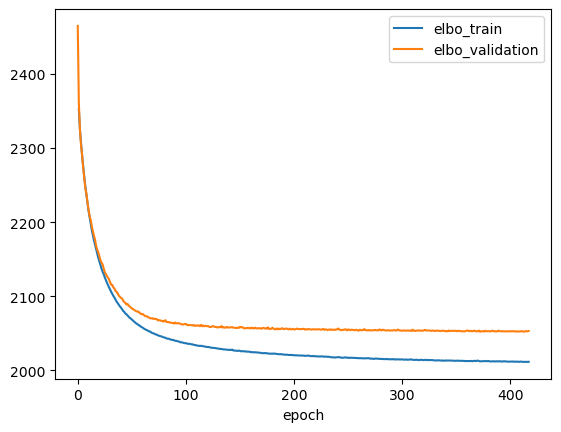

In [8]:
ax = vae.history['elbo_train'][1:].plot()
vae.history['elbo_validation'].plot(ax=ax)

In [9]:
data.obs["celltype_scanvi"] = 'Unknown'
ref_idx = data.obs['batch'] == "reference"
data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]

/tmp/ipykernel_21681/134013430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]


In [10]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=data,
    labels_key="celltype_scanvi",
    unlabeled_category="Unknown",
)

/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [11]:
lvae.train(max_epochs=1000, n_samples_per_label=100)

INFO     Training for 1000 epochs.                                                                                 


2023-04-09 12:17:33 - INFO - GPU available: True (cuda), used: True
2023-04-09 12:17:33 - INFO - TPU available: False, using: 0 TPU cores
2023-04-09 12:17:33 - INFO - IPU available: False, using: 0 IPUs
2023-04-09 12:17:33 - INFO - HPU available: False, using: 0 HPUs
2023-04-09 12:17:33 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 1000/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:40<00:00,  2.33s/it, loss=2.1e+03, v_num=1]

2023-04-09 12:57:14 - INFO - `Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:40<00:00,  2.38s/it, loss=2.1e+03, v_num=1]


<AxesSubplot: xlabel='epoch'>

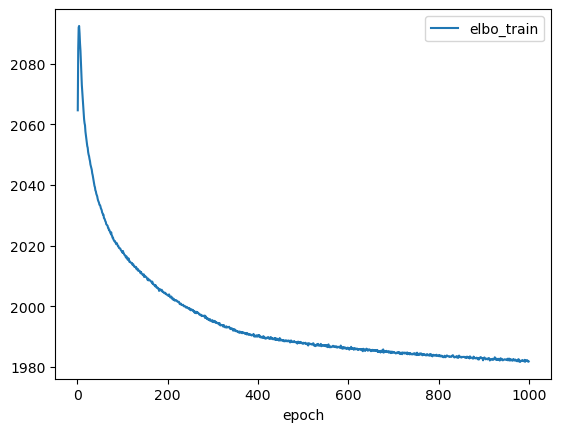

In [12]:
lvae.history['elbo_train'][1:].plot()

We now can perform the label transfer/prediction and obtain the joint embedding of reference and query data.

In [13]:
data.obs["C_scANVI"] = lvae.predict(data)
data.obsm["X_scANVI"] = lvae.get_latent_representation(data)

In [14]:
sc.pp.neighbors(data, use_rep="X_scANVI")
sc.tl.umap(data)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical
/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


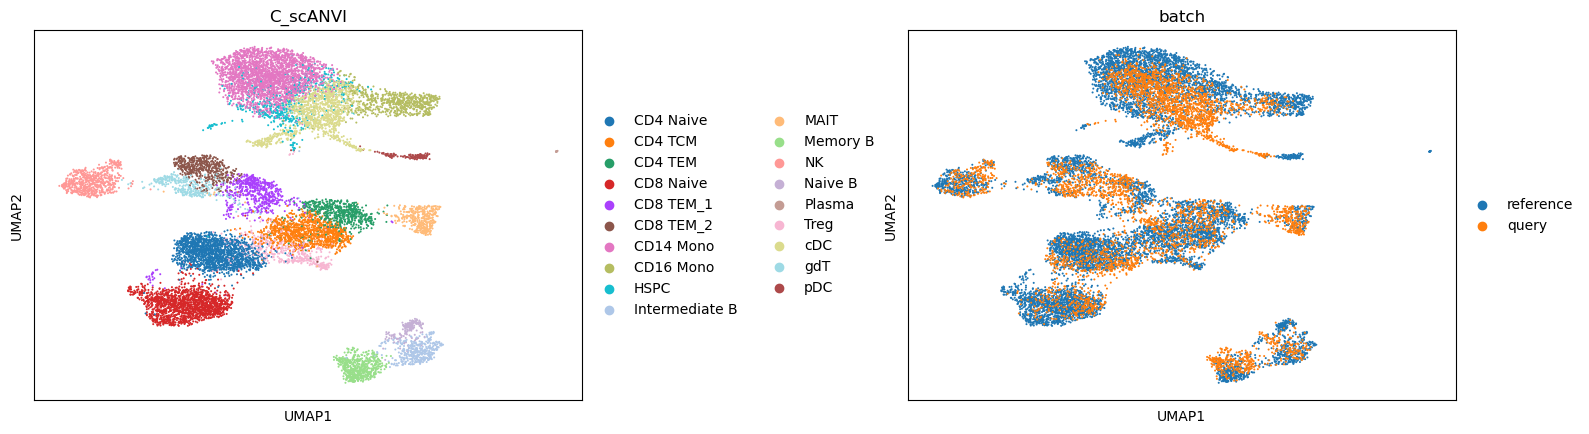

In [15]:
sc.pl.umap(data, color=['C_scANVI', "batch"], wspace=0.45)

Save the predicted cell type labels back to the original cell by bin matrix.

In [16]:
atac = sc.read(snap.datasets.pbmc5k(type="h5ad"))
obs = data.obs
obs = obs[obs['batch'] == 'query']
obs.index = list(map(lambda x: x.split("-query")[0], obs.index))
atac.obs['cell_type'] = obs.loc[atac.obs.index]['C_scANVI']

Updating file 'atac_pbmc_5k.h5ad' from 'https://osf.io/download/y9t83/' to '/home/kaizhang/.cache/snapatac2'.


We can see that the predicted cell type labels are pretty consistent with the leiden cluster labels. Since our ATAC-seq data has fewer cells, we do not have the power to separate CD8 T and CD4 T cells, as well as a few other subtypes.

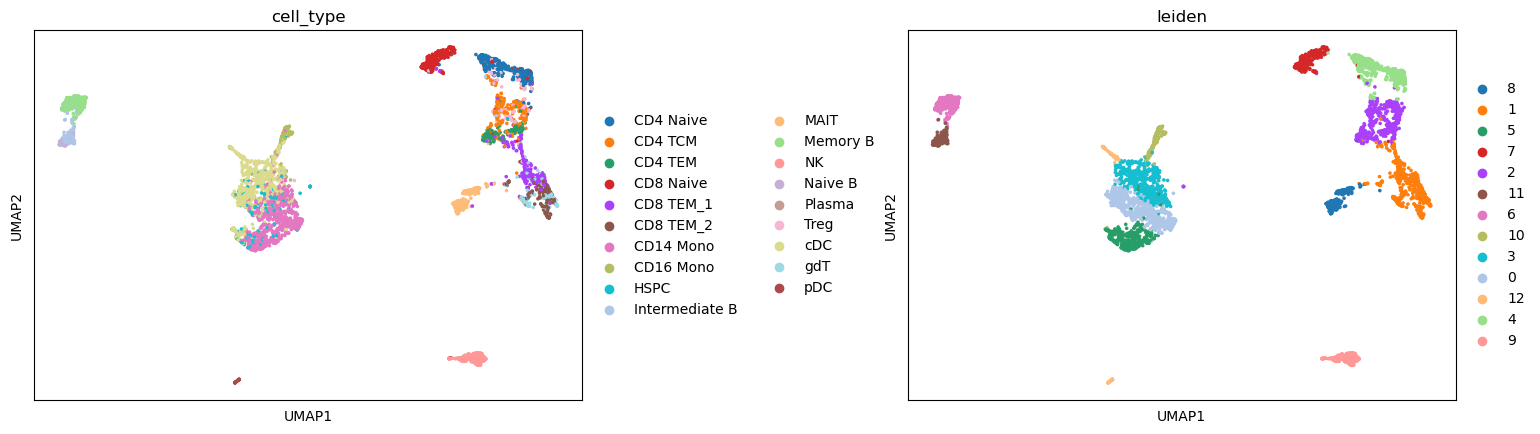

In [17]:
sc.pl.umap(atac, color=['cell_type', "leiden"], wspace=0.45)

In [18]:
from collections import Counter

cell_type_labels = np.unique(atac.obs['cell_type'])

count_table = {}
for cl, ct in zip(atac.obs['leiden'], atac.obs['cell_type']):
    if cl in count_table:
        count_table[cl].append(ct)
    else:
        count_table[cl] = [ct]

mat = []
for cl, counts in count_table.items():
    c = Counter(counts)
    c = np.array([c[ct] for ct in cell_type_labels])
    c = c / c.sum()
    mat.append(c)

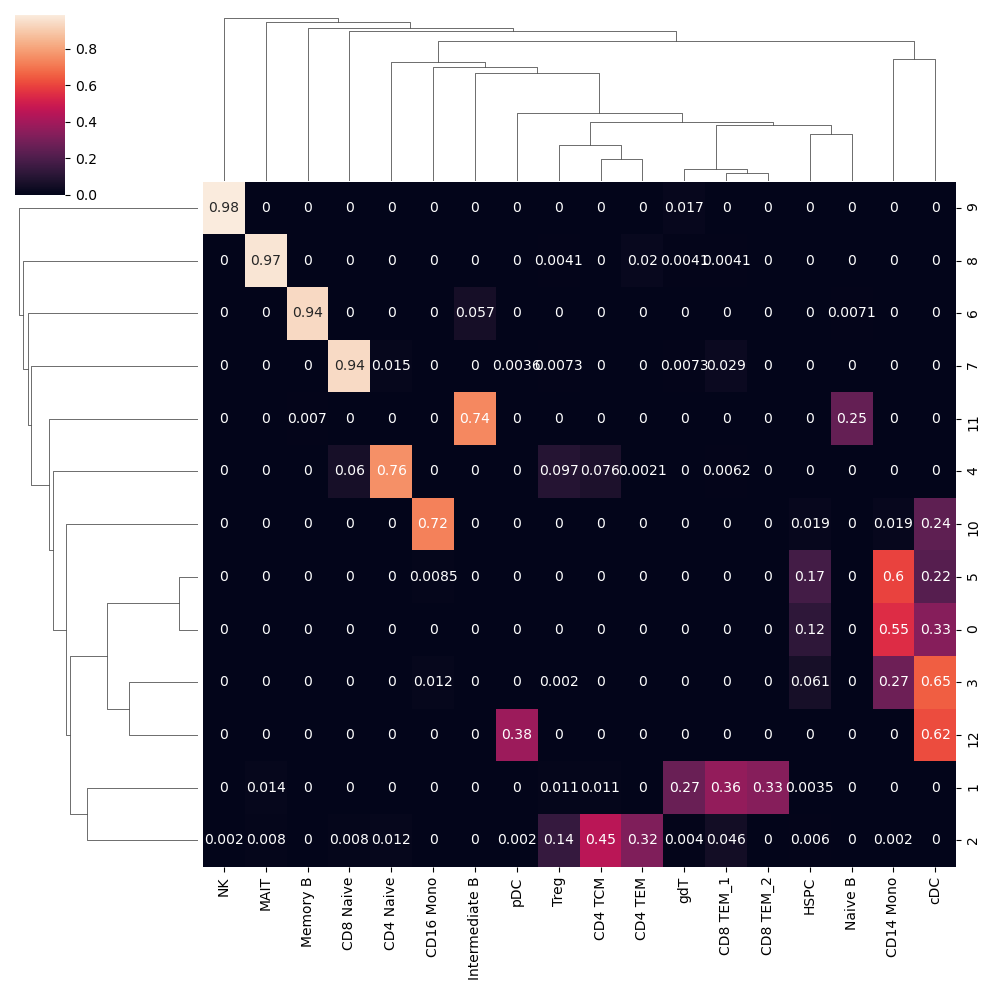

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(
    mat,
    index = count_table.keys(),
    columns = cell_type_labels,
)
sn.clustermap(df_cm, annot=True)

Let's mannually refine the cell type labels at the leiden cluster level, and save the result.

In [25]:
annotation = {
    "0": "CD14 Mono",
    "1": "CD8 TEM",
    "2": "CD4 TCM",
    "3": "CD14 Mono",
    "4": "CD4 Naive",
    "5": "CD14 Mono",
    "6": "Memory B",
    "7": "CD8 Naive",
    "8": "MAIT",
    "9": "NK",
    "10": "CD16 Mono",
    "11": "Naive/Intermediate B",
    "12": "DC",    
}

atac.obs['cell_type'] = [annotation[i] for i in atac.obs['leiden']]

... storing 'cell_type' as categorical
/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


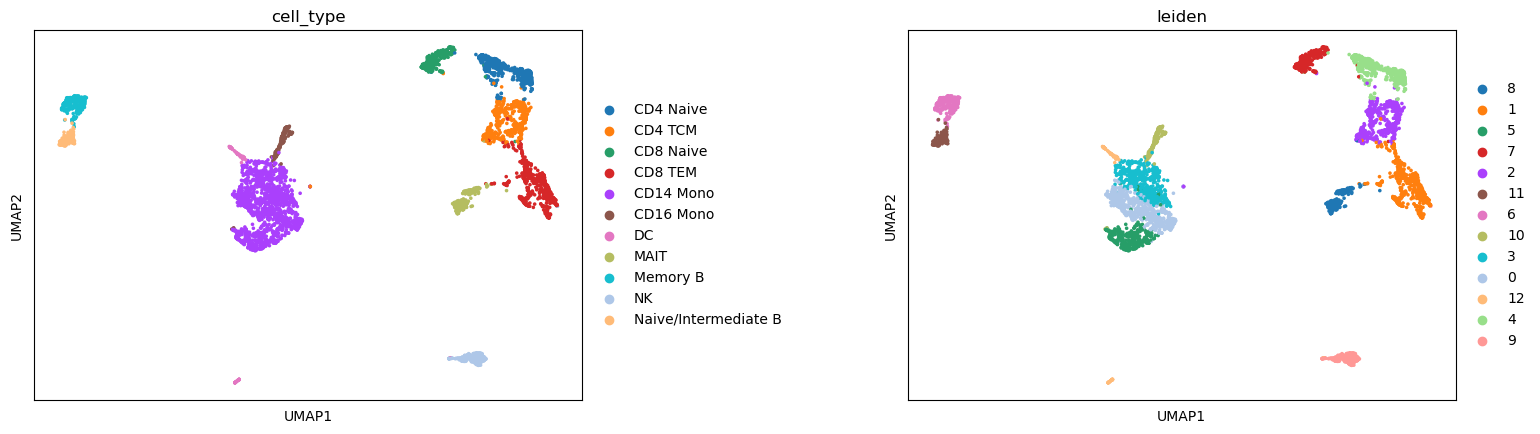

In [26]:
sc.pl.umap(atac, color=['cell_type', "leiden"], wspace=0.45)

In [27]:
atac.write("pbmc5k_annotated.h5ad", compression="gzip")

## What's next?

- [Differential peak analysis](https://kzhang.org/SnapATAC2/tutorials/diff.html)